## Importing Libraries

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import dill
import datetime

## Importing Data

In [3]:
import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/Synthetic Data/Uncentered X/Bounded_Var_Time:2024-04-15 19:35:40, intercept:5,n_train:5000, n_test:1000, tensor_dimensions:[32 32], tensor_mode_ranks:[4 4], separation_rank:2.pkl"
file= open(pkl_file, 'rb')
data = pickle.load(file)
file.close()

X_train_Full = data[0]
print(data[0].shape)

Y_train_Full = data[1]
print(data[1].shape)

X_test_Full = data[2]
print(data[2].shape)

Y_test_Full = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

(5000, 32, 32)
(5000,)
(1000, 32, 32)
(1000,)
(32, 32)


## Setting up Global Parameters

### 1. Tensor Parameters

In [4]:
#importing path 
import sys
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/CodeFiles')

#parameters related to tensor

tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2

### 2. Preprocessing Pipeline

In [5]:
n_train = 650
n_test = 100

#Subset X_train and Y_train
X_train = X_train_Full[0:(n_train),:,:]
Y_train = Y_train_Full[0:(n_train)]

#Subset X_test and Y_test
X_test = X_test_Full[0:(n_test),:,:]
Y_test = Y_test_Full[0:(n_test)]


#Preprocessing

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)


X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)


# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, tensor_dimensions[0],tensor_dimensions[1])
X_test  = X_test_scaled.reshape(n_test, tensor_dimensions[0],tensor_dimensions[1])

#average response value
Y_train_mean = np.mean(Y_train)
#Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)


Sample mean for each feature (across samples): [4.99871322 4.98420917 5.00873521 ... 5.01840176 4.98600789 5.01023623]
Sample variance for each feature (across samples): None
Response Average: 83.56008733093063


In [11]:
# intializing the tensor object 
from LSR_Tensor_2D_v1 import LSR_tensor_dot

hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}

ranks = hypers['ranks']
separation_rank = hypers['separation_rank']
LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
need_intercept = False

#lsr_tensor_CL = LSR_tensor_dot(shape = LSR_tensor_dot_shape, ranks = ranks, separation_rank = separation_rank, intercept = need_intercept)

#keeping a copy of the orginal object
import copy
#lsr_tensor_SGD = copy.deepcopy(lsr_tensor_CL)
#lsr_tensor_GD = copy.deepcopy(lsr_tensor_CL)
#lsr_tensor_initializer = copy.deepcopy(lsr_tensor_CL)

#regularization parameter

lambda1 = 50


In [12]:
#saving the initializer
#formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/RMSProp/Test_loss /Initializers_ExecutionTime_intercept_5_{formatted_time}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}.pkl"

#with open(pkl_file, "wb") as file:
#      dill.dump((lsr_tensor_initializer), file)

In [13]:
#loading previous initializer

#Loading the checkpoints

import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/SGD/Initializer/Initializers_ExecutionTime_intercept_5_2024-06-01 12:20:25, tensor_dimensions:[32 32], tensor_mode_= ranks:[4 4], separation_rank:2.pkl"
file= open(pkl_file, 'rb')
lsr_tensor_initializer = pickle.load(file)
file.close()

lsr_tensor_CL = copy.deepcopy(lsr_tensor_initializer)
lsr_tensor_GD = copy.deepcopy(lsr_tensor_initializer)
lsr_tensor_SGD = copy.deepcopy(lsr_tensor_initializer)


## Closed-Form Solver

In [14]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression_closed import lsr_bcd_regression
from optimization_closed import inner_product, R2, objective_function_vectorized

def train_test(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, B_tensored: np.ndarray,lsr_tensor_CL,lambda1, hypers,Y_train_mean, intercept = False):
  hypers['weight_decay'] = lambda1

  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor, objective_function_values,tensor_iterate,factor_core_iterate = lsr_bcd_regression(lsr_tensor_CL, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')

  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean


  print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  print("Y Test Predicted: ", Y_test_predicted.flatten())
  print("Y Test Actual: ", Y_test.flatten())

  return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,tensor_iterate,factor_core_iterate


In [15]:
#hyper parameters
normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,tensor_iterate_closed,factor_core_iterate_closed = train_test(X_train, Y_train, X_test, Y_test, B_tensored,lsr_tensor_CL, lambda1, hypers, Y_train_mean,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/SGD/Closed_form_Data_ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("Alpha chosen for model: ", lambda1)
print("Test Normalized Estimation Error: ", normalized_estimation_error)
print("Test NMSE Loss: ", test_nmse_loss)
print("Test R2 Loss: ", test_R2_loss)
print("Test Correlation: ", test_correlation)

with open(pkl_file, "wb") as file:
      dill.dump((X_train,X_test,Y_train,Y_test,lambda1, normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,tensor_iterate_closed,factor_core_iterate_closed), file)

Separable Function
Objective Function Value: 3364004.1803554227
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separ

## Gradient Descent 

In [18]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression_gd import lsr_bcd_regression
from optimization import inner_product, R2, objective_function_vectorized

def train_test_gd(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, lambda1, hypers,Y_train_mean,lsr_tensor_GD,B_tensored = None,intercept = False):
  hypers['weight_decay'] = lambda1

  
  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor, objective_function_values, gradient_values,tensor_iterate_gd,factor_core_iterate_gd = lsr_bcd_regression(lsr_tensor_GD, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')
  print(expanded_lsr.shape)
  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean

  print('---------------------------Testing with Best Lambda------------------------------')
  #print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  if B_tensored is not None:
    normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  #print("Y Test Predicted: ", Y_test_predicted.flatten())
  #print("Y Test Actual: ", Y_test.flatten())

  if B_tensored is not None:
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,tensor_iterate_gd,factor_core_iterate_gd
  else:
    normalized_estimation_error = np.inf
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,tensor_iterate_gd,factor_core_iterate_gd



In [19]:
lsr_tensor_GD = copy.deepcopy(lsr_tensor_initializer)
learning_rate = None 
epochs = 100
batch_size = None



hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size}

normalized_estimation_error_GD, test_nmse_loss_GD, test_R2_loss_GD, test_correlation_GD, objective_function_values_GD,gradient_values_GD,tensor_iterate_GD,factor_core_iterate_GD = train_test_gd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_GD,B_tensored,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/SGD/Gradient_Descent_ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("GD_Alpha chosen for model: ", lambda1)
print("GD_Test Normalized Estimation Error: ", normalized_estimation_error_GD)
print("GD_Test NMSE Loss: ", test_nmse_loss_GD)
print("GD_Test R2 Loss: ", test_R2_loss_GD)
print("GD_Test Correlation: ", test_correlation_GD)

with open(pkl_file, "wb") as file:
  dill.dump((lambda1, normalized_estimation_error_GD, test_nmse_loss_GD, test_R2_loss_GD, test_correlation_GD, objective_function_values_GD,tensor_iterate_GD,factor_core_iterate_GD), file)

Objective Function Value: 3364004.1803554227
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Value of t is: 2.1849228048693275e-05
Gradient Norm for linear.weight: 163255.375
Value of t is: 3.128752186632013e-05
Gradient Norm for linear.weight: 81674.1875
Value of t is: 2.212218093917489e-05
Gradient Norm for linear.weight: 68959.8203125
Value of t is: 3.149625288621822e-05
Gradient Norm for linear.weight: 43293.5546875
Value of t is: 2.2150400354012498e-05
Gradient Norm for linear.weight: 40293.26953125
Value of t is: 3.14464135735422e-05
Gradient Norm for linear.weight: 27309.71875
Value of t is: 2.2123587680731862e-05
Gradient Norm for linear.weight: 27013.73046875
Value of t is: 3.144798609868297e-05
Gradient Norm for linear.weight: 19194.666015625
Value of t is: 2.2159558901999916e

## Stochastic Solver

### 1. Train Test Function

In [20]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression import lsr_bcd_regression
from optimization import inner_product, R2, objective_function_vectorized

def train_test_sgd(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, lambda1, hypers,Y_train_mean,lsr_tensor_SGD,B_tensored = None,intercept = False):
  hypers['weight_decay'] = lambda1

  
  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_SGD
  lsr_tensor, objective_function_values, gradient_values,iterate_differences,epoch_level_gradients,epoch_level_function,tensor_iteration,factor_core_iterate = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')
  print(expanded_lsr.shape)
  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean

  print('---------------------------Testing with Best Lambda------------------------------')
  #print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  if B_tensored is not None:
    normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  print("Y Test Predicted: ", Y_test_predicted.flatten())
  print("Y Test Actual: ", Y_test.flatten())

  if B_tensored is not None:
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_differences,epoch_level_gradients,epoch_level_function,tensor_iteration,factor_core_iterate
  else:
    normalized_estimation_error = np.inf
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_differences,epoch_level_gradients,epoch_level_function,tensor_iteration,factor_core_iterate



### 2. Block 1 Evaluation

In [21]:
#loading previous initializer

#Loading the checkpoints

import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/SGD/Initializer/Initializers_ExecutionTime_intercept_5_2024-06-01 12:20:25, tensor_dimensions:[32 32], tensor_mode_= ranks:[4 4], separation_rank:2.pkl"
file= open(pkl_file, 'rb')
lsr_tensor_initializer = pickle.load(file)
file.close()


In [22]:
learning_rates = [0.000009]

for idx,lr in enumerate (learning_rates):   
    
    print('')
    print('-------------------------------------Learning Rate',lr,'-----------------------------------------')
    lsr_tensor_SGD = copy.deepcopy(lsr_tensor_initializer )
    learning_rate = lr
    epochs = 100
    batch_size = 64

    momentum = 0
    nesterov = False
    decay_factor = 0.99
    hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size, 'momentum':momentum, 'nesterov': nesterov, 'decay_factor': decay_factor}

    normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD,iterate_differences_SGD,epoch_level_gradients_SGD,epoch_level_function,tensor_iteration_SGD,factor_core_iterate_SGD = train_test_sgd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_SGD,B_tensored,intercept= False)

  
    #Get current time and store in variable
    formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    max_iter = hypers['max_iter']
    pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/RMSProp/New Experiment/SGD_learning_rate{learning_rate}_intercept5_,ExecutionTime{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

    with open(pkl_file, "wb") as file:
      dill.dump((lsr_tensor_SGD,lambda1, normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD, iterate_differences_SGD,epoch_level_gradients_SGD,epoch_level_function,tensor_iteration_SGD,factor_core_iterate_SGD), file)


    print("Error Report on Testing _ With best Lambda")
    print("SGD_Alpha chosen for model: ", lambda1)
    print("SGD_Test Normalized Estimation Error: ", normalized_estimation_error_SGD)
    print("SGD_Test NMSE Loss: ", test_nmse_loss_SGD)
    print("SGD_Test R2 Loss: ", test_R2_loss_SGD)
    print("SGD_Test Correlation: ", test_correlation_SGD)
    print("Objective Function Values", objective_function_values_SGD[0,1,2])




-------------------------------------Learning Rate 9e-06 -----------------------------------------
Objective Function Value: 3364004.1803554227
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Epoch [1/100], Loss: 2039531.3750, Gap to Optimality: 2039531.3750, NMSE: 0.9220354557037354, Correlation: 0.3765185611412446, R2: 0.07796453419453953
Epoch [2/100], Loss: 1955042.5000, Gap to Optimality: 1955042.5000, NMSE: 0.8837716579437256, Correlation: 0.39695526839641043, R2: 0.11622833517893572
Epoch [3/100], Loss: 1903546.5000, Gap to Optimality: 1903546.5000, NMSE: 0.8604175448417664, Correlation: 0.4111939263363751, R2: 0.139582443194336
Epoch [4/100], Loss: 1867640.2500, Gap to Optimality: 1867640.2500, NMSE: 0.844113290309906, Correlation: 0.42481143686903833, R2: 0.15588669478413886
E

### Loading Checkpoints

In [ ]:

import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/SGD_learning_rate9.1e-06_intercept5_,ExecutionTime2024-06-03 00:46:22, n_train_650,n_test_100, tensor_dimensions:[32 32], tensor_mode_= ranks:[4 4], separation_rank:2, max_iter=50.pkl"
file= open(pkl_file, 'rb')
checkpoint_data = pickle.load(file)
file.close()

lsr_tens = checkpoint_data[12]
print(len(lsr_tens))

#loading the checkpoint 
lsr_tensor_SGD = lsr_tens[39]

#Objective Function Values 
objective_function_values_SGD__loaded = checkpoint_data[6]


50


In [ ]:
#Copying initializer just in case 

lsr_tensor_SGD_intermediate = copy.deepcopy(lsr_tensor_SGD)

### 4. Block 2 If Needed

In [ ]:
lsr_tensor_SGD = copy.deepcopy(lsr_tensor_SGD_intermediate)
learning_rate = 0.00001
epochs = 100
batch_size = 64

momentum = 0
nesterov = False


hypers = {'max_iter': 20, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size, 'momentum':momentum, 'nesterov': nesterov}

normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD,iterate_differences_SGD,epoch_level_gradients_SGD,epoch_level_function,tensor_iteration_SGD,factor_core_iterate_SGD = train_test_sgd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_SGD,B_tensored,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/Sub Exp/Learning_Rate_{learning_rate}ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

with open(pkl_file, "wb") as file:
    dill.dump((lsr_tensor_SGD,lambda1, normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD, iterate_differences_SGD,epoch_level_gradients_SGD,epoch_level_function,tensor_iteration_SGD,factor_core_iterate_SGD), file)


print("Error Report on Testing _ With best Lambda")
print("SGD_Alpha chosen for model: ", lambda1)
print("SGD_Test Normalized Estimation Error: ", normalized_estimation_error_SGD)
print("SGD_Test NMSE Loss: ", test_nmse_loss_SGD)
print("SGD_Test R2 Loss: ", test_R2_loss_SGD)
print("SGD_Test Correlation: ", test_correlation_SGD)



Separable Function
Objective Function Value: 90856.0520079361
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Epoch [1/100], Loss: 81927.5469, Gap to Optimality: 81927.5469, NMSE: 0.6503265500068665, Correlation: 0.8787195994952005, R2: 0.3496734203782331
Epoch [2/100], Loss: 55128.8477, Gap to Optimality: 55128.8477, NMSE: 0.4371381402015686, Correlation: 0.9289657577978264, R2: 0.5628618165252582
Epoch [3/100], Loss: 38903.3984, Gap to Optimality: 38903.3984, NMSE: 0.30785828828811646, Correlation: 0.9423873736613998, R2: 0.6921416768976774
Epoch [4/100], Loss: 28787.3320, Gap to Optimality: 28787.3320, NMSE: 0.2271047830581665, Correlation: 0.9498575067730822, R2: 0.7728951916154889
Epoch [5/100], Loss: 22274.6367, Gap to Optimality: 22274.6367, NMSE: 0.1750049740076065, Correlation:

In [ ]:
print("Final Objevtive Function Vlaue:", objective_function_values_SGD[-1,1,2])
print("Epoch Level Gradients Final: ",epoch_level_gradients_SGD[-1,:,:,-1])

Final Objevtive Function Vlaue: 95901.94569656427
Epoch Level Gradients Final:  [[1443.70996094 1415.97290039  359.06570435]
 [1568.02270508 1505.87890625  359.06570435]]


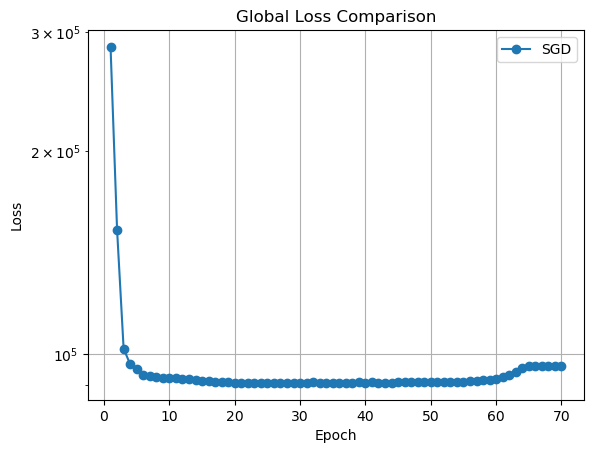

Final Objective Function Value SGD: [95901.94569656]


In [ ]:
import matplotlib.pyplot as plt

# Plotting SGD Loss
# Plotting SGD Loss
objective_function_values_SGD_1 = objective_function_values_SGD__loaded[:, 1, 2].reshape(-1,1)

#concatanating the arrays
reshaped_array = objective_function_values_SGD[:, 1, 2].reshape(-1, 1)
# Concatenate along the first axis (rows)
objective_function_values_SGD_2 = np.concatenate((objective_function_values_SGD_1, reshaped_array), axis=0)

#plot SGD
plt.plot(range(1, len(objective_function_values_SGD_2) + 1), objective_function_values_SGD_2, label='SGD',marker = 'o')

# Plotting CLOSED
#plt.plot(range(1, len(objective_function_values) + 1), objective_function_values[:, 1, 2], label='CLOSED',marker = 'o')

# Plotting GD
#plt.plot(range(1, len(objective_function_values_GD) + 1), objective_function_values_GD[:, 1, 2], label='GD',marker = 'o')

# Setting the title and labels
plt.title('Global Loss Comparison')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Adding a legend to distinguish the two plots
plt.legend()

# Display the plot
plt.show()

print('Final Objective Function Value SGD:',objective_function_values_SGD_2[-1])


In [ ]:
import matplotlib.pyplot as plt


#All loss function values in one plot

plt.figure()

# Plotting SGD
plt.plot(range(1, len(objective_function_values_SGD) + 1), objective_function_values_SGD[:, 1, 2], label='SGD',marker = 'o')

# Plotting CLOSED
plt.plot(range(1, len(objective_function_values) + 1), objective_function_values[:, 1, 2], label='CLOSED',marker = 'o')

# Plotting GD
plt.plot(range(1, len(objective_function_values_GD) + 1), objective_function_values_GD[:, 1, 2], label='GD',marker = 'o')

# Setting the title and labels
plt.title('Global Loss Comparison')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Adding a legend to distinguish the two plots
plt.legend()

# Display the plot
plt.show()

print('Final Objective Function Value CLOSED:',objective_function_values[-1,1,2])
print('Final Objective Function Value SGD:',objective_function_values_SGD[-1,1,2])
print('Final Objective Function Value GD:',objective_function_values_GD[-1,1,2])

ValueError: operands could not be broadcast together with shapes (50,) (10,) 